# TAYSIR competition - Track 1 Starter Kit

### Welcome!

This is a notebook to show the structure of a code to participate to the competition.

You can also check the baseline notebook (available in the same archive) for more details about the TAYSIR models and how to use them.

## Prepare your environment

In [1]:
%pip install --upgrade mlflow torch transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import mlflow
from utils import predict, PytorchInference
import sys
import pandas as pd

### Persisting results for logging

In [3]:
def persist_results(dataset, learning_result, max_extraction_time):
    result = dict()
    extracted_model = learning_result.model
    
    result.update({ 
                'Instance': dataset,
                'Number of Extracted States': len(extracted_model.states) ,   
                'EquivalenceQuery': learning_result.info['equivalence_queries_count'], 
                'MembershipQuery': learning_result.info['membership_queries_count'], 
                'Duration': learning_result.info['duration'], 
                'TimeBound': max_extraction_time,
                'HistoricModelsAmount': len(learning_result.info['history']) 
                })
    
    wandb.config.update(result)
    wandb.finish()

### Model extraction

In [4]:
import pickle
from utils import predict, PytorchInference
import numpy as np
from wrapper import MlflowDFA
from submit_tools_fix import save_function
from pythautomata.utilities.uniform_word_sequence_generator import UniformWordSequenceGenerator
from pythautomata.model_exporters.dot_exporters.dfa_dot_exporting_strategy import DfaDotExportingStrategy
from pymodelextractor.teachers.pac_comparison_strategy import PACComparisonStrategy
from pymodelextractor.teachers.general_teacher import GeneralTeacher
from pymodelextractor.factories.lstar_factory import LStarFactory
from pythautomata.base_types.alphabet import Alphabet
from utils import test_model
from pymodelextractor.learners.observation_table_learners.translators.partial_dfa_translator import PartialDFATranslator
import wandb

TRACK = 1 #always for his track
DATASET = 7

max_extraction_time = 60
max_sequence_len = 80
min_sequence_len = 10
epsilon = 0.01
delta = 0.01

# params of wandb log
params = dict()
params[f"DATASET_{DATASET}"] = {"max_extraction_time":max_extraction_time, "max_sequence_len":max_sequence_len, 
                       "min_sequence_len":min_sequence_len, "epsilon":epsilon, "delta":delta}

teacher_type = 'GeneralTeacher'
sampling_type = 'UniformWordSequenceGenerator'
learner_type = 'GeneralLStarLearner'
    
params.update({
        'teacher_type': teacher_type, 
        'sampling_type': sampling_type, 
        'learner_type': learner_type
    })

# Initialize wandb
wandb.init(
        # Set the project where this run will be logged
        project="taysir_track_1",
        # Track hyperparameters and run metadata
        config=params
    ) 

counter = 0
observation_table = None

model_name = f"models/1.{DATASET}.taysir.model"
model = mlflow.pytorch.load_model(model_name)
model.eval()

file = f"datasets/1.{DATASET}.taysir.valid.words"

empty_sequence_len = 2
with open(file) as f:
    a = f.readline() #Skip first line (number of sequences, alphabet size)
    headline = a.split(' ')
    alphabet_size = int(headline[1].strip())
    alphabet = Alphabet.from_strings([str(x) for x in range(alphabet_size - empty_sequence_len)])

name = "Track: " + str(TRACK) + " - DataSet: " + str(DATASET) + "-  partial n° " + str(counter)
target_model = PytorchInference(alphabet, model, name)

sequence_generator = UniformWordSequenceGenerator(alphabet, max_seq_length=max_sequence_len,
                                                        min_seq_length=min_sequence_len)

comparator = PACComparisonStrategy(target_model_alphabet = alphabet, epsilon = epsilon, delta = delta,
                                   sequence_generator = sequence_generator)

teacher = GeneralTeacher(target_model, comparator)

learner = LStarFactory.get_partial_dfa_lstar_learner(max_time=max_extraction_time)

name = "Track: " + str(TRACK) + " - DataSet: " + str(DATASET) + "-  partial n° " + str(counter)
res = learner.learn(teacher, observation_table)

persist_results(DATASET, res, max_extraction_time)

wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: neural_checker (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.14.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


2023/04/16 21:28:43 WARNING mlflow.pytorch: Stored model version '1.11.0+cu102' does not match installed PyTorch version '2.0.0+cu117'


### Some quick metrics

In [6]:
print("Result info:", res.info)
print("---------------------------")
print("Number of extracted states:", len(res.model.states))
print("---------------------------")
print("Historic models length: ", len(res.info["history"]))

Result info: {'equivalence_queries_count': 1, 'membership_queries_count': 129, 'observation_table': <pymodelextractor.learners.observation_table_learners.general_observation_table.GeneralObservationTable object at 0x7f160cad4a00>, 'duration': 60, 'history': [<pythautomata.automata.deterministic_finite_automaton.DeterministicFiniteAutomaton object at 0x7f1604417130>]}
---------------------------
Number of extracted states: 2
---------------------------
Historic models length:  1


### Test with uniform length sequences

In [13]:
from pythautomata.base_types.alphabet import Alphabet

file = f"datasets/1.{DATASET}.taysir.valid.words"

alphabet = None
sequences = []

#In the competition the empty sequence is defined as [alphabet_size - 2, alphabet size -1]
#For example with the alphabet of size 22 the empty sequence is [20, 21]
empty_sequence_len = 2

with open(file) as f:
    a = f.readline() #Skip first line (number of sequences, alphabet size)
    headline = a.split(' ')
    alphabet_size = int(headline[1].strip())
    alphabet = Alphabet.from_strings([str(x) for x in range(alphabet_size - empty_sequence_len)])
    
    for line in f:
        line = line.strip()
        seq = line.split(' ')
        seq = [int(i) for i in seq[1:]] #Remove first value (length of sequence) and cast to int
        sequences.append(seq)

In [21]:
# Get validation sequence max and min length
max_len = 0
min_len = 1000
sequence_len = []

for sequence in sequences:
    sequence_len.append(len(sequence))
    if(len(sequence) > max_len):
        max_len = len(sequence)
    if(len(sequence) < min_len):
        min_len = len(sequence)
    
        
print("Max sequence length for DATASET",DATASET, "is:", max_len)
print("Min sequence length for DATASET",DATASET, "is:", min_len)

Max sequence length for DATASET 7 is: 10626
Min sequence length for DATASET 7 is: 7


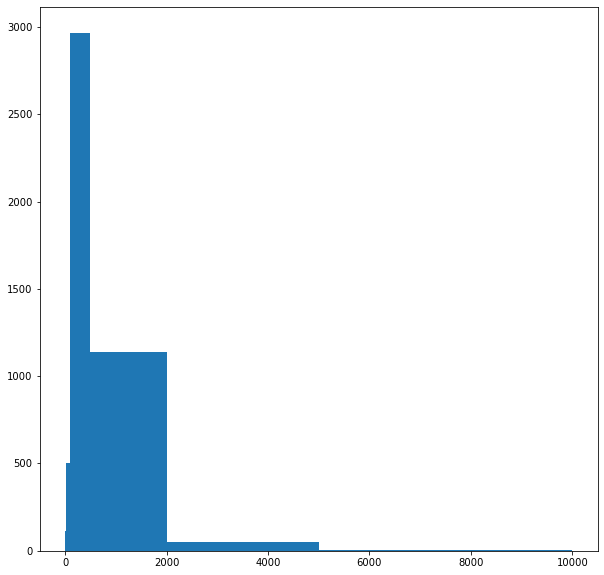

In [28]:
# Histogram
from matplotlib import pyplot as plt
import numpy as np

a = np.array(sequence_len)
 
fig, ax = plt.subplots(figsize =(10, 10))
ax.hist(a, bins = [0, 20, 100, 500, 2000, 5000, 10000])
 
# Show plot
plt.show()

In [33]:
result = test_model(target_model, res.model, max_seq_len=100, min_seq_len=20, sequence_amount=1000)
print(1 - np.mean(result))

0.0


### Submission

In [ ]:
res.model.name = "Dataset"+str(DATASET)+"-1Acc"
res.model.export()

In [ ]:
from fast_dfa_converter import FastDeterministicFiniteAutomatonConverter as Converter

fast_dfa = Converter().to_fast_dfa(res.model)

In [ ]:
from wrapper import MlflowDFA
from submit_tools_fix import save_function

#mlflow_dfa = MlflowDFA(fast_dfa)
save_function(fast_dfa, len(res.model.alphabet), target_model.name)